In [1]:
%who

Interactive namespace is empty.


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
from tqdm.auto import tqdm

main_dir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'

# load the threshold data file & select the drought period of interest
events_file = 'sm_droughts/events_*.nc'
ds_events = xr.open_mfdataset(main_dir + events_file)

drght_time_slice = slice('1911-01-01', '2020-12-31')
drght_name = 'full_record'
drght_dir = main_dir + 'GLM_results_' + drght_name + '/validation/'
if not os.path.exists(drght_dir):
    os.makedirs(drght_dir)

da_events = ds_events['sm_drought'].sel(time = drght_time_slice)

from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

ts_list = [2, 6]#, 12]
for ts in ts_list:
    da_events_afterTs = (da_events[:,:,(7*ts-1):len(da_events.time)]).rename('sm_drought_after_' + str(ts) + 'weeks').assign_coords({'time': da_events.time.values[0:(len(da_events.time)-7*ts+1)]})
    for year, sample in tqdm(da_events_afterTs.groupby('time.year')):
        out_file = drght_dir + 'events_after_' + str(ts) + 'weeks_' + str(year) + '.nc'
        # sample.to_netcdf(out_file)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42857 instead
  warnings.warn(


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

In [1]:
# validation data based on P-E-Q alone

import xarray as xr
import numpy as np
import pandas as pd
import os
from tqdm.auto import tqdm

main_dir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'

# load the threshold data file & select the drought period of interest
PmEQ_events_file = 'sm_droughts/PmEQ_events_*.nc'
ds_events_PmEQ = xr.open_mfdataset(main_dir + PmEQ_events_file)

drght_time_slice = slice('1911-01-01', '2020-05-31')
drght_name = 'full_record'
drght_dir = main_dir + 'GLM_results_' + drght_name + '/validation/'
if not os.path.exists(drght_dir):
    os.makedirs(drght_dir)

# there are the P-E-Q thersholds that are the target accumulations for ending drought
da_events_PmEQ = ds_events_PmEQ['PminusEQ'].sel(time = drght_time_slice)

# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)
# client

for ts in [12]: #[2, 6, 12]:
    # the accumulations of P-E-Q that actually occurred (calculated using rolling mean)
    PmEQ_roll_files = drght_dir + 'PminusEQ_week' + str(ts) + '_roll_daily/PminusEQ_daily_roll_' + str(ts) + 'weeks*.nc'
    ds_roll_PmEQ = xr.open_mfdataset(PmEQ_roll_files)
    da_roll_PmEQ = ds_roll_PmEQ['PminusEQ'].sel(time = drght_time_slice)

    # get the actual events that exceed the corresponding required threshold
    da_events_exceed_thresh = xr.where(da_roll_PmEQ >= da_events_PmEQ.sel(timescale = ts), 1, 0).rename('events_exceed_thersh')

    # get the total number of required threshold events (some of these would be exceeded above)
    # ensure that the time_slice of the total number of events match that of the rolling sum data (last few weeks would be missing due to rolling sum)
    time_slice = slice(pd.to_datetime(da_events_exceed_thresh.time[0].values).strftime("%Y-%m-%d"),
                       pd.to_datetime(da_events_exceed_thresh.time[-1].values).strftime("%Y-%m-%d"))
    da_total_events = xr.where(da_events_PmEQ.sel(timescale = ts, time = time_slice) > 0, 1, 0).rename('total_events')

    for year, sample in tqdm(da_total_events.groupby('time.year')):
        out_file = drght_dir + 'PmEQ_events/total_required_events_' + str(ts) + 'weeks_' + str(year) + '.nc'
        sample.to_netcdf(out_file)

    for year, sample in tqdm(da_events_exceed_thresh.groupby('time.year')):
        out_file = drght_dir + 'PmEQ_events/events_exceed_thresh_' + str(ts) + 'weeks_' + str(year) + '.nc'
        sample.to_netcdf(out_file)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

In [8]:
import xarray as xr
import numpy as np
import pandas as pd
import os

main_dir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'

drght_time_slice = slice('1911-01-01', '1982-12-31')
drght_name = 'full_record' #'recent_drght'
drght_dir = main_dir + 'GLM_results_' + drght_name + '/validation/'
fullrec_dir = main_dir + 'GLM_results_full_record/validation/'

# load the threshold data file & select the drought period of interest
events_file = 'sm_droughts/events_*.nc'
ds_events = xr.open_mfdataset(main_dir + events_file)
ds_events = ds_events.sel(time = drght_time_slice)

# load the status of drought after 'ts' weeeks
drought_status = []
ts_list = [2, 6, 12]
for ts in ts_list:
    ts_files = fullrec_dir + 'events_after_' + str(ts) + 'weeks_*.nc'
    ds = xr.open_mfdataset(ts_files)
    drought_status.append(ds.sel(time = drght_time_slice).rename({'sm_drought_after_' + str(ts) + 'weeks': 'drought_status'}))
    del ds
ds_drght_status = xr.concat(drought_status, "timescale").assign_coords({'timescale': ts_list})

# get GLM results
# glm_dir = main_dir + 'GLM_results_' + drght_name + '/'
# glm_file = 'PminusEQ_results_weeks_2_6_12.nc'
# ds_glm = xr.open_dataset(glm_dir + glm_file)

In [12]:
ds_drght_status['drought_status']

,Array,Chunk
Bytes,21.63 GiB,102.76 MiB
Shape,"(3, 141, 261, 26298)","(1, 141, 261, 366)"
Count,1638 Tasks,216 Chunks
Type,int64,numpy.ndarray


In [13]:
# get GLM results
glm_dir = main_dir + 'GLM_results_' + drght_name + '/'
glm_file = 'PminusEQ_results_weeks_2_6_12*.nc'
ds_glm = xr.open_mfdataset(glm_dir + glm_file)
ds_glm

<xarray.Dataset>
Dimensions:          (lat: 141, lon: 261, time: 28490, timescale: 3, glm_parameter: 3)
Coordinates:
  * lat              (lat) float32 -32.0 -32.05 -32.1 ... -38.9 -38.95 -39.0
  * lon              (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 152.0
    quantile         float64 0.3
  * time             (time) datetime64[ns] 1911-01-01 1911-01-02 ... 2001-12-31
    dayofyear        (time) int64 dask.array<chunksize=(365,), meta=np.ndarray>
    parameter        <U4 'PmEQ'
  * timescale        (timescale) int64 2 6 12
  * glm_parameter    (glm_parameter) object 'Intercept' 'soi' 'dmi'
Data variables:
    glm_probability  (timescale, time, lat, lon) float64 dask.array<chunksize=(3, 365, 141, 261), meta=np.ndarray>
    glm_params       (timescale, time, lat, lon, glm_parameter) float64 dask.array<chunksize=(3, 365, 141, 261, 3), meta=np.ndarray>
    glm_pvalues      (timescale, time, lat, lon, glm_parameter) float64 dask.array<chunksize=(3, 365, 141, 261, 3), meta=np.ndarray>
    glm_aic          (timescale, time, lat, lon) float64 dask.array<chunksize=(3, 365, 141, 261), meta=np.ndarray>
    soi              (timescale, time) float64 dask.array<chunksize=(3, 365), meta=np.ndarray>
    dmi              (timescale, time) float64 dask.array<chunksize=(3, 365), meta=np.ndarray>

In [15]:
ds_glm['glm_probability']

<xarray.DataArray 'glm_probability' (timescale: 3, time: 28490, lat: 141, lon: 261)>
dask.array<concatenate, shape=(3, 28490, 141, 261), dtype=float64, chunksize=(3, 366, 141, 261), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon        (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
    quantile   float64 0.3
  * time       (time) datetime64[ns] 1911-01-01 1911-01-02 ... 2001-12-31
    dayofyear  (time) int64 dask.array<chunksize=(365,), meta=np.ndarray>
    parameter  <U4 'PmEQ'
  * timescale  (timescale) int64 2 6 12

In [ ]:
%%time

# calculations for probability bands
band_name = np.linspace(0.1, 0.9, 9)
low = np.linspace(0.05, 0.85, 9)
high = np.linspace(0.15, 0.95, 9)

for i in [0]: #range(len(band_name)):
    # select the GLM estimated probabilities that fall in the band
    sel_prob_band = ds_glm['glm_probability'].where((ds_glm['glm_probability'] >= low[i]) & (ds_glm['glm_probability'] < high[i]))
    da_drght_status_prob_band = ds_drght_status.where(sel_prob_band > 0)
    da_sum_drght_status_prob_band = da_drght_status_prob_band['drought_status'].sum('time')
    
    out_file = drght_dir + 'drought_status_band' + str(band_name[i]) + '.nc'
    da_drght_status_prob_band.to_netcdf(out_file)
    out_file = drght_dir + 'sum_drought_status_band' + str(band_name[i]) + '.nc'
    da_sum_drght_status_prob_band.to_netcdf(out_file)
    
    sum_drght_events = []
    drght_events = []
    for ts in ts_list:
        drght_events.append((ds_events['sm_drought'].where(sel_prob_band.sel(timescale=ts) > 0)))
        sum_drght_events.append((ds_events['sm_drought'].where(sel_prob_band.sel(timescale=ts) > 0)).sum('time'))
    da_drght_events = xr.concat(drght_events, 'timescale').assign_coords({'timescale': ts_list})
    da_sum_drght_events = xr.concat(sum_drght_events, 'timescale').assign_coords({'timescale': ts_list})
    
    out_file = drght_dir + 'drought_events_band' + str(band_name[i]) + '.nc'
    da_drght_events.to_netcdf(out_file)
    out_file = drght_dir + 'sum_drought_events_band' + str(band_name[i]) + '.nc'
    da_sum_drght_events.to_netcdf(out_file)

    da_prob_drought_break = 1 - (da_sum_drght_status_prob_band/da_sum_drght_events).rename('hist_prob')
    out_file = drght_dir + 'hist_prob_drought_break_band' + str(band_name[i]) + '.nc'
    da_prob_drought_break.to_netcdf(out_file)

### Diagnosing model underestimation

In [4]:
# Using a small region for testing

lat_slice = slice(-34.5, -35)
lon_slice = slice(142.5, 143)

import xarray as xr
import numpy as np
import pandas as pd
import os

main_dir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'

drght_time_slice = slice('1911-01-01', '2020-05-31')
drght_name = 'full_record' #'recent_drght'
drght_dir = main_dir + 'GLM_results_' + drght_name + '/validation/'
fullrec_dir = main_dir + 'GLM_results_full_record/validation/'

# load the threshold data file & select the drought period of interest
events_file = 'sm_droughts/events_*.nc'
ds_events = xr.open_mfdataset(main_dir + events_file)
ds_events = ds_events.sel(time = drght_time_slice, lat = lat_slice, lon = lon_slice)

# load the status of drought after 'ts' weeeks
drought_status = []
ts_list = [2, 6, 12]
for ts in ts_list:
    ts_files = fullrec_dir + 'events_after_' + str(ts) + 'weeks_*.nc'
    ds = xr.open_mfdataset(ts_files)
    drought_status.append(ds.sel(time = drght_time_slice, lat = lat_slice, lon = lon_slice).rename({'sm_drought_after_' + str(ts) + 'weeks': 'drought_status'}))
    del ds
ds_drght_status = xr.concat(drought_status, "timescale").assign_coords({'timescale': ts_list})

# get GLM results
glm_dir = main_dir + 'GLM_results_' + drght_name + '/'
glm_file = 'PminusEQ_results_weeks_2_6_12*.nc'
ds_glm_temp = xr.open_mfdataset(glm_dir + glm_file)
ds_glm = ds_glm_temp.sel(lat = lat_slice, lon = lon_slice, time = drght_time_slice)

# calculations for probability bands
band_name = np.linspace(0.1, 0.9, 9)
low = np.linspace(0.05, 0.85, 9)
high = np.linspace(0.15, 0.95, 9)

for i in [1]: #[1, 3, 5, 7]: #range(len(band_name)):
    # select the GLM estimated probabilities that fall in the band
    sel_prob_band = ds_glm['glm_probability'].where((ds_glm['glm_probability'] >= low[i]) & (ds_glm['glm_probability'] < high[i]))
    da_drght_status_prob_band = ds_drght_status.where(sel_prob_band > 0)
    da_sum_drght_status_prob_band = da_drght_status_prob_band['drought_status'].sum('time')
    
    out_file = drght_dir + 'drought_status_band' + str(band_name[i]) + '.nc'
    # da_drght_status_prob_band.to_netcdf(out_file)
    out_file = drght_dir + 'sum_drought_status_band' + str(band_name[i]) + '.nc'
    # da_sum_drght_status_prob_band.to_netcdf(out_file)
    
    sum_drght_events = []
    drght_events = []
    for ts in ts_list:
        drght_events.append((ds_events['sm_drought'].where(sel_prob_band.sel(timescale=ts) > 0)))
        sum_drght_events.append((ds_events['sm_drought'].where(sel_prob_band.sel(timescale=ts) > 0)).sum('time'))
    da_drght_events = xr.concat(drght_events, 'timescale').assign_coords({'timescale': ts_list})
    da_sum_drght_events = xr.concat(sum_drght_events, 'timescale').assign_coords({'timescale': ts_list})
    
    out_file = drght_dir + 'drought_events_band' + str(band_name[i]) + '.nc'
    # da_drght_events.to_netcdf(out_file)
    out_file = drght_dir + 'sum_drought_events_band' + str(band_name[i]) + '.nc'
    # da_sum_drght_events.to_netcdf(out_file)

    da_prob_drought_break = 1 - (da_sum_drght_status_prob_band/da_sum_drght_events).rename('hist_prob')
    out_file = drght_dir + 'hist_prob_drought_break_band' + str(band_name[i]) + '.nc'
    # da_prob_drought_break.to_netcdf(out_file)

    # print("Band " + str(i))
    # nanInd1 = np.where(np.isnan(da_drght_events))
    # nanInd2 = np.where(np.isnan(da_drght_status_prob_band['drought_status']))
    # print(np.array_equal(nanInd1, nanInd2))

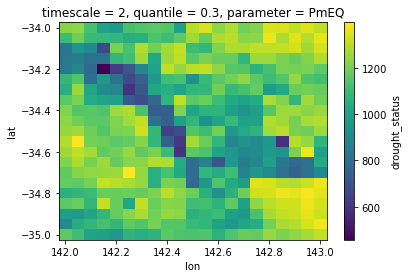

In [28]:
da_drght_status_prob_band['drought_status'].sum(['time']).sel(timescale = 2).plot()

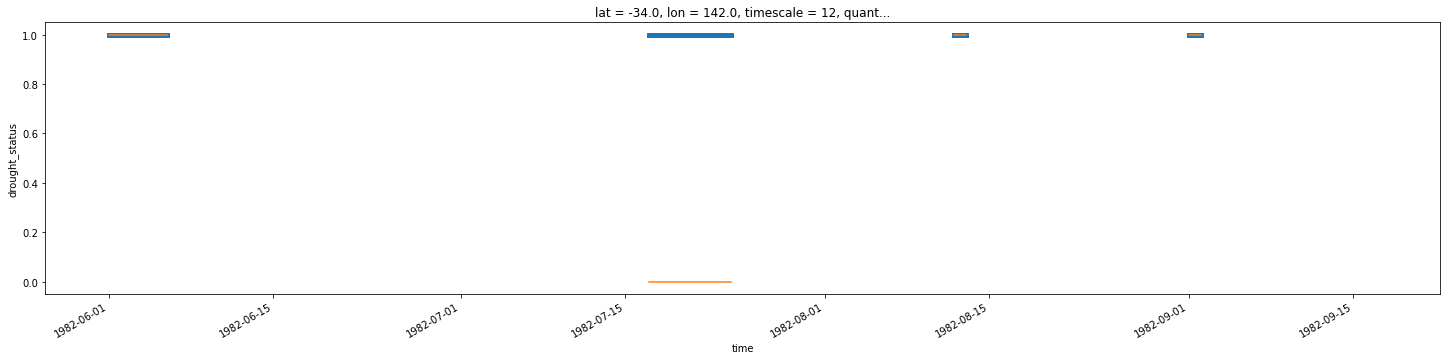

In [38]:
da_drght_events[2, 0, 0, -1000:].plot(size=5, aspect=5, linewidth=5)
da_drght_status_prob_band['drought_status'][2, 0, 0, -1000:].plot()#color="r")

In [43]:
nanInd1 = np.where(np.isnan(da_drght_events))
nanInd1

(array([0, 0, 0, ..., 2, 2, 2]),
 array([ 0,  0,  0, ..., 20, 20, 20]),
 array([ 0,  0,  0, ..., 20, 20, 20]),
 array([    0,     1,     2, ..., 26295, 26296, 26297]))

In [42]:
nanInd2 = np.where(np.isnan(da_drght_status_prob_band['drought_status']))
nanInd2

(array([0, 0, 0, ..., 2, 2, 2]),
 array([ 0,  0,  0, ..., 20, 20, 20]),
 array([ 0,  0,  0, ..., 20, 20, 20]),
 array([    0,     1,     2, ..., 26295, 26296, 26297]))

In [44]:
np.array_equal(nanInd1, nanInd2)

True

In [ ]:
## calculate the historical probabilities only using the data that was used to build the model

ts = 6


### Perform validation using 'P-E-Q' thresholds as the criteria
### To answer the question:
#### Is the lower skill score because the exceedence model is not accurate or is it because the P-E-Q to SM depth relationship is not good enough?

In [88]:
# put together the code for validation based on P-E-Q
# to be submitted as a job on Gadi

import xarray as xr
import numpy as np
import pandas as pd
import os

main_dir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'

drght_time_slice = slice('1911-01-01', '2020-05-31')
drght_name = 'full_record' #'recent_drght'
drght_dir = main_dir + 'GLM_results_' + drght_name + '/validation/'

# load the status of drought after 'ts' weeeks
total_events = []
exceed_events = []
ts_list = [2, 6, 12]

for ts in [2]: #ts_list:
    # load the total events and actual exceeded events files (1 for events, 0 for no events)
    total_events_file = 'PmEQ_events/total_required_events_' + str(ts) + 'weeks*.nc'
    exceed_events_file = 'PmEQ_events/events_exceed_thresh_' + str(ts) + 'weeks*.nc'

    ds_total_events_temp = xr.open_mfdataset(drght_dir + total_events_file)
    ds_total_events = ds_total_events_temp.sel(time = drght_time_slice)

    ds_exceed_events_temp = xr.open_mfdataset(drght_dir + exceed_events_file)
    ds_exceed_events = ds_exceed_events_temp.sel(time = drght_time_slice)

    # get GLM results
    glm_dir = main_dir + 'GLM_results_' + drght_name + '/'
    glm_file = 'PminusEQ_results_weeks_2_6_12*.nc'
    ds_glm_temp = xr.open_mfdataset(glm_dir + glm_file)
    ds_glm = ds_glm_temp.sel(time = drght_time_slice, timescale = ts)

    # calculations for probability bands
    band_name = np.linspace(0.1, 0.9, 9).round(2)
    low = np.linspace(0.05, 0.85, 9)
    high = np.linspace(0.15, 0.95, 9)
    
    for i in [band_no]:

        # select the GLM estimated probabilities that fall in the band
        sel_prob_band = ds_glm['glm_probability'].where((ds_glm['glm_probability'] >= low[i]) & (ds_glm['glm_probability'] < high[i]))
        out_file = drght_dir + 'PmEQ_results/glm_probability_prob_band' + str(band_name[i]) + '.nc'
        # sel_prob_band.to_netcdf(out_file)
        
        # get all desired events corresponding to the band
        da_total_events_prob_band = ds_total_events['total_events'].where(sel_prob_band > 0)
        # da_sum_total_events = da_total_events_prob_band.sum('time')
        # out_file = drght_dir + 'PmEQ_results/hist_prob_drought_break_band' + str(band_name[i]) + '.nc'

        # get all events that exceeded thresholds
        da_exceed_events_prob_band = ds_exceed_events['events_exceed_thersh'].where(sel_prob_band > 0)
        # da_sum_exceed_events = da_exceed_events_prob_band.sum('time')

        da_prob_drought_break = (da_exceed_events_prob_band.sum('time')/da_total_events_prob_band.sum('time')).rename('hist_prob')
        out_file = drght_dir + 'PmEQ_results/hist_prob_drought_break_band' + str(band_name[i]) + '.nc'
        # da_prob_drought_break.to_netcdf(out_file)
    
    

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


### The validation using P-E-Q also shows an underestimation. 
### Does the underestimation exist even if I use the exact time points that I used to build the model in the validation?

In [2]:
# put together the code for validation based on P-E-Q
# to be submitted as a job on Gadi

import xarray as xr
import numpy as np
import pandas as pd
import os

main_dir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'

drght_time_slice = slice('1911-01-01', '2020-05-31')
drght_name = 'full_record' #'recent_drght'
drght_dir = main_dir + 'GLM_results_' + drght_name + '/validation/'

# load the status of drought after 'ts' weeeks
total_events = []
exceed_events = []
ts_list = [2, 6, 12]

band_no = 1

for ts in [2]: #ts_list:
    # load the total events and actual exceeded events files (1 for events, 0 for no events)
    total_events_file = 'PmEQ_events/total_required_events_' + str(ts) + 'weeks*.nc'
    exceed_events_file = 'PmEQ_events/events_exceed_thresh_' + str(ts) + 'weeks*.nc'

    ds_total_events_temp = xr.open_mfdataset(drght_dir + total_events_file)
    ds_total_events = ds_total_events_temp.sel(time = drght_time_slice)

    ds_exceed_events_temp = xr.open_mfdataset(drght_dir + exceed_events_file)
    ds_exceed_events = ds_exceed_events_temp.sel(time = drght_time_slice)

    # get the time points that were used to fit the GLM model
    PmEQ_data_dir = main_dir + 'PminusEQ_week' + str(ts) + '/'
    ds_PmEQ = xr.open_mfdataset(PmEQ_data_dir + 'PminusEQ_week' + str(ts) + '_*_*.nc')
    PmEQ_data_time = ds_PmEQ['time'].values
    
    # get GLM results
    glm_dir = main_dir + 'GLM_results_' + drght_name + '/'
    glm_file = 'PminusEQ_results_weeks_2_6_12*.nc'
    ds_glm_temp = xr.open_mfdataset(glm_dir + glm_file)
    ds_glm = ds_glm_temp.sel(time = PmEQ_data_time, timescale = ts)

    # calculations for probability bands
    band_name = np.linspace(0.1, 0.9, 9).round(2)
    low = np.linspace(0.05, 0.85, 9)
    high = np.linspace(0.15, 0.95, 9)
    
    for i in [band_no]:

        # select the GLM estimated probabilities that fall in the band
        sel_prob_band = ds_glm['glm_probability'].where((ds_glm['glm_probability'] >= low[i]) & (ds_glm['glm_probability'] < high[i]))
        out_file = drght_dir + 'PmEQ_results/glm_probability_prob_band' + str(band_name[i]) + '.nc'
        # sel_prob_band.to_netcdf(out_file)
        
        # get all desired events corresponding to the band
        da_total_events_prob_band = ds_total_events['total_events'].where(sel_prob_band > 0)
        # da_sum_total_events = da_total_events_prob_band.sum('time')
        # out_file = drght_dir + 'PmEQ_results/hist_prob_drought_break_band' + str(band_name[i]) + '.nc'

        # get all events that exceeded thresholds
        da_exceed_events_prob_band = ds_exceed_events['events_exceed_thersh'].where(sel_prob_band > 0)
        # da_sum_exceed_events = da_exceed_events_prob_band.sum('time')

        da_prob_drought_break = (da_exceed_events_prob_band.sum('time')/da_total_events_prob_band.sum('time')).rename('hist_prob')
        out_file = drght_dir + 'PmEQ_results/hist_prob_drought_break_band' + str(band_name[i]) + '.nc'
        # da_prob_drought_break.to_netcdf(out_file)
    
    

### Using the exact time points vs. all time points in the full record does not make a difference.
#### Are the biases associated with positive or negative values of the SOI?

In [1]:
# put together the code for validation based on P-E-Q
# to be submitted as a job on Gadi

import xarray as xr
import numpy as np
import pandas as pd
import os

main_dir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'

drght_time_slice = slice('1911-01-01', '2020-05-31')
drght_name = 'full_record' #'recent_drght'
drght_dir = main_dir + 'GLM_results_' + drght_name + '/validation/'

############################################
# GET THE SST PREDICTORS
############################################
# get the sst data
sst_dir = '/g/data/w97/ad9701/p_prob_analysis/sst_data/'
pNames = ['soi', 'sami', 'dmi', 'nino34_anom', 'nino4_anom']
pFiles = ['soi_monthly.nc', 'newsam.1957.2021.nc', 'dmi.had.long.data.nc', 'nino34.long.anom.data.nc', 'nino4.long.anom.data.nc']
for p in np.arange(len(pNames)):
    ds_temp = xr.open_dataset(sst_dir+pFiles[p])
    if (p>0):
        ds_p[pNames[p]]=ds_temp[pNames[p]]
    else:
        ds_p = ds_temp
    del ds_temp

# load the status of drought after 'ts' weeeks
total_events = []
exceed_events = []
ts_list = [2, 6, 12]

band_no = 1
for ts in [2]: #ts_list:
    # load the total events and actual exceeded events files (1 for events, 0 for no events)
    total_events_file = 'PmEQ_events/total_required_events_' + str(ts) + 'weeks*.nc'
    exceed_events_file = 'PmEQ_events/events_exceed_thresh_' + str(ts) + 'weeks*.nc'

    ds_total_events_temp = xr.open_mfdataset(drght_dir + total_events_file)
    ds_total_events = ds_total_events_temp.sel(time = drght_time_slice)

    ds_exceed_events_temp = xr.open_mfdataset(drght_dir + exceed_events_file)
    ds_exceed_events = ds_exceed_events_temp.sel(time = drght_time_slice)
    
    # get GLM results
    glm_dir = main_dir + 'GLM_results_' + drght_name + '/'
    glm_file = 'PminusEQ_results_weeks_2_6_12*.nc'
    ds_glm_temp = xr.open_mfdataset(glm_dir + glm_file)
    ds_glm = ds_glm_temp.sel(time = drght_time_slice, timescale = ts)
    time_bymon = np.array(pd.to_datetime(ds_glm.time).to_period('M').to_timestamp().floor('D'))
    da_soi = ds_p['soi'].sel(time = time_bymon).assign_coords({'time':ds_glm['time'].values})
    # da_soineg = ds_p['soi'].where(ds_p['soi']<0).sel(time = time_bymon).assign_coords({'time':ds_glm['time'].values})

    # calculations for probability bands
    band_name = np.linspace(0.1, 0.9, 9).round(2)
    low = np.linspace(0.05, 0.85, 9)
    high = np.linspace(0.15, 0.95, 9)
    
    for i in [band_no]:
        # select the GLM estimated probabilities that fall in the band
        sel_prob_band = ds_glm['glm_probability'].where((ds_glm['glm_probability'] >= low[i]) & (ds_glm['glm_probability'] < high[i]))
        sel_prob_band_soipos = sel_prob_band.where(da_soi>=0)
        sel_prob_band_soineg = sel_prob_band.where(da_soi<0)
        out_file_pos = drght_dir + 'PmEQ_results/soipos_glm_probability_prob_band' + str(band_name[i]) + '.nc'
        out_file_neg = drght_dir + 'PmEQ_results/soineg_glm_probability_prob_band' + str(band_name[i]) + '.nc'
        # sel_prob_band_soipos.to_netcdf(out_file_pos)
        # sel_prob_band_soineg.to_netcdf(out_file_neg)
        
        # get all desired events corresponding to the band
        da_total_events_prob_band_soipos = ds_total_events['total_events'].where(sel_prob_band_soipos > 0)
        da_total_events_prob_band_soineg = ds_total_events['total_events'].where(sel_prob_band_soineg > 0)

        # get all events that exceeded thresholds
        da_exceed_events_prob_band_soipos = ds_exceed_events['events_exceed_thersh'].where(sel_prob_band_soipos > 0)
        da_exceed_events_prob_band_soineg = ds_exceed_events['events_exceed_thersh'].where(sel_prob_band_soineg > 0)
        
        da_prob_drought_break_soipos = (da_exceed_events_prob_band_soipos.sum('time')/da_total_events_prob_band_soipos.sum('time')).rename('hist_prob')
        da_prob_drought_break_soineg = (da_exceed_events_prob_band_soineg.sum('time')/da_total_events_prob_band_soineg.sum('time')).rename('hist_prob')
        
        out_file_pos = drght_dir + 'PmEQ_results/soipos_hist_prob_drought_break_band' + str(band_name[i]) + '.nc'
        out_file_neg = drght_dir + 'PmEQ_results/soineg_hist_prob_drought_break_band' + str(band_name[i]) + '.nc'
        # da_prob_drought_break_soipos.to_netcdf(out_file_pos)
        # da_prob_drought_break_soineg.to_netcdf(out_file_neg)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_c

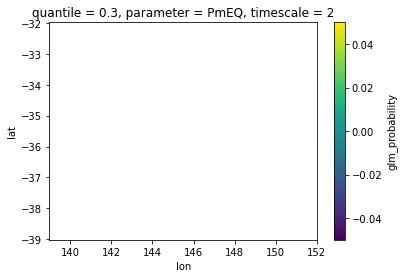

In [15]:
sel_prob_band_soipos[152:250,:,:].mean('time').plot()

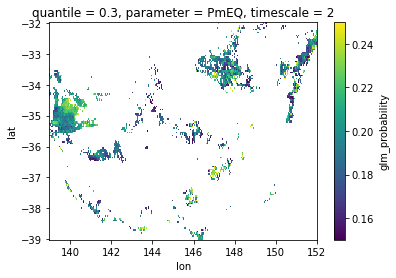

In [16]:
sel_prob_band_soineg[152:250,:,:].mean('time').plot()

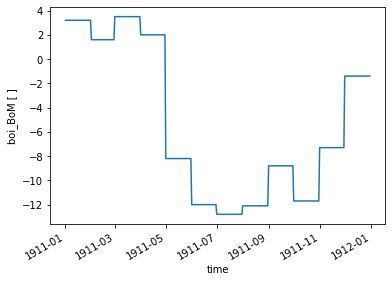

In [12]:
da_soi[0:365].plot()

### The validation using P-E-Q also shows an underestimation. Is this prominent during any season?

In [1]:
band_no=1

# put together the code for validation based on P-E-Q
# to be submitted as a job on Gadi

import xarray as xr
import numpy as np
import pandas as pd
import os

main_dir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'

drght_time_slice = slice('1911-01-01', '2020-05-31')
drght_name = 'full_record' #'recent_drght'
drght_dir = main_dir + 'GLM_results_' + drght_name + '/validation/'

# load the status of drought after 'ts' weeeks
total_events = []
exceed_events = []
ts_list = [2, 6, 12]

for ts in [2]: #ts_list:
    # load the total events and actual exceeded events files (1 for events, 0 for no events)
    total_events_file = 'PmEQ_events/total_required_events_' + str(ts) + 'weeks*.nc'
    exceed_events_file = 'PmEQ_events/events_exceed_thresh_' + str(ts) + 'weeks*.nc'

    ds_total_events_temp = xr.open_mfdataset(drght_dir + total_events_file)
    ds_total_events = ds_total_events_temp.sel(time = drght_time_slice)

    ds_exceed_events_temp = xr.open_mfdataset(drght_dir + exceed_events_file)
    ds_exceed_events = ds_exceed_events_temp.sel(time = drght_time_slice)

    # get GLM results
    glm_dir = main_dir + 'GLM_results_' + drght_name + '/'
    glm_file = 'PminusEQ_results_weeks_2_6_12*.nc'
    ds_glm_temp = xr.open_mfdataset(glm_dir + glm_file)
    ds_glm = ds_glm_temp.sel(time = drght_time_slice, timescale = ts)

    # calculations for probability bands
    band_name = np.linspace(0.1, 0.9, 9).round(2)
    low = np.linspace(0.05, 0.85, 9)
    high = np.linspace(0.15, 0.95, 9)
    
    for i in [band_no]:

        # select the GLM estimated probabilities that fall in the band
        sel_prob_band = ds_glm['glm_probability'].where((ds_glm['glm_probability'] >= low[i]) & (ds_glm['glm_probability'] < high[i]))
        sel_prob_band_seas_mean = sel_prob_band.groupby('time.season').mean('time')
        out_file = drght_dir + 'PmEQ_results/mean_seas_glm_probability_prob_band' + str(band_name[i]) + '.nc'
        sel_prob_band.to_netcdf(out_file)
        
        # get all desired events corresponding to the band
        da_total_events_prob_band = ds_total_events['total_events'].where(sel_prob_band > 0)
        # da_sum_total_events = da_total_events_prob_band.sum('time')
        # out_file = drght_dir + 'PmEQ_results/hist_prob_drought_break_band' + str(band_name[i]) + '.nc'

        # get all events that exceeded thresholds
        da_exceed_events_prob_band = ds_exceed_events['events_exceed_thersh'].where(sel_prob_band > 0)
        # da_sum_exceed_events = da_exceed_events_prob_band.sum('time')

        da_prob_drought_break_seas = (da_exceed_events_prob_band.groupby('time.season').sum('time')/da_total_events_prob_band.groupby('time.season').sum('time')).rename('hist_prob')
        out_file = drght_dir + 'PmEQ_results/hist_seas_prob_drought_break_band' + str(band_name[i]) + '.nc'
        da_prob_drought_break_seas.to_netcdf(out_file)
    
    

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [6]:
da_prob_drought_break.sel(season = "DJF")

<xarray.DataArray 'hist_prob' (lat: 141, lon: 261)>
dask.array<getitem, shape=(141, 261), dtype=float64, chunksize=(141, 261), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -39.0 -38.95 -38.9 -38.85 ... -32.1 -32.05 -32.0
  * lon        (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
    quantile   float64 0.3
    parameter  <U4 'PmEQ'
    timescale  int64 2
    season     <U3 'DJF'

### Working with the full record of data

In [5]:
# checking if calculation for all dates have been completed
import xarray as xr
import numpy as np
import pandas as pd
import os

main_dir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'
drght_time_slice = slice('1911-01-01', '2020-12-31')
drght_name = 'full_record'
drght_dir = main_dir + 'GLM_results_' + drght_name

import glob
from datetime import datetime, timedelta

ts = 6
for year in range(1911, 2021):
    glm_dir = main_dir + 'GLM_results_' + drght_name + '/PminusEQ_week' + str(ts) + '/by_day/'
    glm_files = glob.glob(glm_dir + 'GLM_results_*' + str(year) + '-*.nc')
    nfiles = len(glm_files)

    t = np.arange(datetime(year,1,1), datetime(year+1,1,1), timedelta(days=1)).astype(datetime)
    ndates = len(t)
    diff = ndates - nfiles
    if (diff!=0):
        print('year ' + str(year) + ' has a mismatch')
        print('no of files = ' + str(nfiles) + '; no of days = ' + str(ndates))

In [7]:
# checking if calculation for the sets have been completed
import xarray as xr
import numpy as np
import pandas as pd
import os

main_dir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'
drght_time_slice = slice('1911-01-01', '2020-12-31')
drght_name = 'full_record'
drght_dir = main_dir + 'GLM_results_' + drght_name

import glob
from datetime import datetime, timedelta

ts = 12
for sub_dir in range(2, ts*7+1):
    glm_dir = main_dir + 'GLM_results_' + drght_name + '/PminusEQ_week' + str(ts) + '/set' + str(sub_dir) + '/by_day/'
    glm_files = glob.glob(glm_dir + 'GLM_results_*.nc')
    nfiles = len(glm_files)
    
    diff = 294 - nfiles
    if (diff!=0):
        diff_year = []
        for year in range(2000, 2021):
            glm_files = glob.glob(glm_dir + 'GLM_results_*' + str(year) + '-*.nc')
            nfiles_yr = len(glm_files)
            if nfiles_yr < 14:
                diff_year.append(year)
        print('sub_dir set' + str(sub_dir) + ' has a mismatch in years ' + ','.join([str(x) for x in diff_year]))
        print('no of files = ' + str(nfiles) + '; no of days = 294')

In [ ]:
# far too many files to load and save together

import xarray as xr
import numpy as np
import pandas as pd
import os

main_dir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'
drght_name = 'full_record'
drght_dir = main_dir + 'GLM_results_' + drght_name

ts_list = [2, 6, 12]

for year in range(1982, 2021):  # add years upto 2020 once all calculations are complete
    ds_glm_list = []
    for ts in ts_list:
        glm_dir = main_dir + 'GLM_results_' + drght_name + '/PminusEQ_week' + str(ts) + '/by_day/'
        glm_files = 'GLM_results_*' + str(year) + '*.nc'
        ds_glm = xr.open_mfdataset(glm_dir + glm_files, combine = "nested", concat_dim = "time")
        ds_glm_list.append(ds_glm)
        del ds_glm
    ds_glm = xr.concat(ds_glm_list, 'timescale')

    # save ds_glm
    out_file = main_dir + 'GLM_results_' + drght_name + '/PminusEQ_results_weeks_' + '_'.join([str(x) for x in ts_list]) + '_' + str(year) + '.nc'
    ds_glm.to_netcdf(out_file)

### Scratch Space

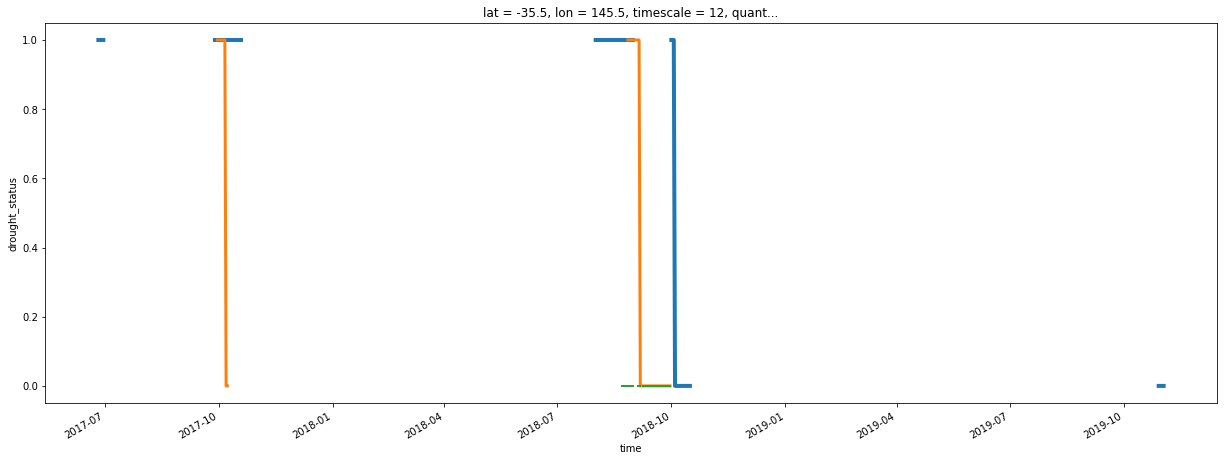

In [41]:
drght_status_prob_band['drought_status'][0,70, 130, :].plot(size=7, aspect=3, linewidth=4)
drght_status_prob_band['drought_status'][1,70, 130, :].plot(linewidth=3)
drght_status_prob_band['drought_status'][2,70, 130, :].plot(linewidth=2)

In [42]:
pd.unique(drght_status_prob_band['drought_status'][0,70, 130, :])

array([nan,  1.,  0.])

In [26]:
np.linspace(0.05, 0.85, 9)

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85])

In [27]:
np.linspace(0.15, 0.95, 9)

array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


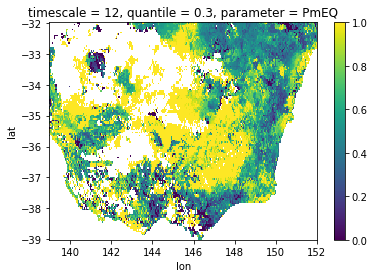

In [21]:
prob_drought_break[2,:,:].plot()

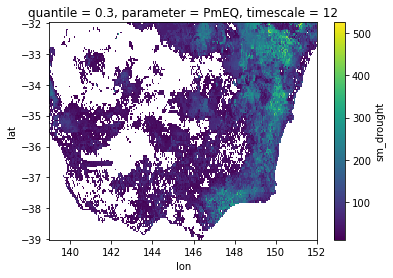

In [23]:
sum_drght_events_prob_band[2,:,:].where(sum_drght_events_prob_band[2,:,:]>10).plot()

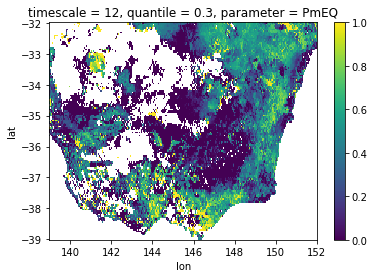

In [13]:
prob_drought_continued[2,:,:].plot()

In [3]:
sum_drght_events_prob_band

<xarray.DataArray 'sm_drought' (timescale: 3, lat: 141, lon: 261)>
dask.array<concatenate, shape=(3, 141, 261), dtype=float64, chunksize=(1, 141, 261), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon        (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
    quantile   float64 0.3
    parameter  <U4 'PmEQ'
  * timescale  (timescale) int64 2 6 12

In [51]:
# all drought days in that prob band for each timescale
drght_prob_band_2 = ds_events['sm_drought'].where(test_prob_band.sel(timescale=2) > 0)
drght_prob_band_4 = ds_events['sm_drought'].where(test_prob_band.sel(timescale=) > 0)
drght_prob_band_6 = ds_events['sm_drought'].where(test_prob_band.sel(timescale=6) > 0)

KeyError: 4

In [19]:
ds_drght_status

<xarray.Dataset>
Dimensions:         (lat: 141, lon: 261, time: 1186, timescale: 3)
Coordinates:
  * lat             (lat) float32 -32.0 -32.05 -32.1 ... -38.9 -38.95 -39.0
  * lon             (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 152.0
  * time            (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2020-03-31
  * timescale       (timescale) int64 2 6 12
Data variables:
    drought_status  (timescale, lat, lon, time) int64 dask.array<chunksize=(1, 141, 261, 365), meta=np.ndarray>

In [43]:
ds_events

<xarray.Dataset>
Dimensions:     (lat: 141, lon: 261, time: 1186)
Coordinates:
  * lat         (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon         (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 152.0
  * time        (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2020-03-31
Data variables:
    sm_drought  (lat, lon, time) int64 dask.array<chunksize=(141, 261, 1186), meta=np.ndarray>

In [12]:
# get GLM results
glm_dir = main_dir + 'GLM_results_' + drght_name + '/'
glm_file = 'PminusEQ_results_weeks_2_6_12.nc'
ds_glm = xr.open_dataset(glm_dir + glm_file)
ds_glm

<xarray.Dataset>
Dimensions:          (lat: 141, lon: 261, time: 1186, timescale: 3, glm_parameter: 3)
Coordinates:
  * lat              (lat) float32 -32.0 -32.05 -32.1 ... -38.9 -38.95 -39.0
  * lon              (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 152.0
    quantile         float64 ...
  * time             (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2020-03-31
    dayofyear        (time) int64 ...
    parameter        object ...
  * timescale        (timescale) int64 2 6 12
  * glm_parameter    (glm_parameter) object 'Intercept' 'soi' 'dmi'
Data variables:
    glm_probability  (timescale, time, lat, lon) float64 ...
    glm_params       (timescale, time, lat, lon, glm_parameter) float64 ...
    glm_pvalues      (timescale, time, lat, lon, glm_parameter) float64 ...
    glm_aic          (timescale, time, lat, lon) float64 ...
    soi              (timescale, time) float64 ...
    dmi              (timescale, time) float64 ...

In [49]:
ds_events['sm_drought']

<xarray.DataArray 'sm_drought' (lat: 141, lon: 261, time: 1186)>
dask.array<getitem, shape=(141, 261, 1186), dtype=int64, chunksize=(141, 261, 1186), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon      (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
  * time     (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2020-03-31

In [50]:
test_prob_band

<xarray.DataArray 'glm_probability' (timescale: 3, time: 1186, lat: 141, lon: 261)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * lat        (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon        (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
    quantile   float64 0.3
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2020-03-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 9 10 ... 83 84 85 86 87 88 89 90 91
    parameter  <U4 'PmEQ'
  * timescale  (timescale) int64 2 6 12

In [47]:
ds_events

<xarray.Dataset>
Dimensions:     (lat: 141, lon: 261, time: 1186)
Coordinates:
  * lat         (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon         (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 152.0
  * time        (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2020-03-31
Data variables:
    sm_drought  (lat, lon, time) int64 dask.array<chunksize=(141, 261, 1186), meta=np.ndarray>

In [46]:
nDrght_prob_band

<xarray.DataArray 'drought_status' (timescale: 3, lat: 141, lon: 261)>
dask.array<sum-aggregate, shape=(3, 141, 261), dtype=float64, chunksize=(1, 141, 261), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon        (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
  * timescale  (timescale) int64 2 6 12
    quantile   float64 0.3
    parameter  <U4 'PmEQ'

In [40]:
drght_status_prob_band['drought_status'][0, 70, 130, 0:500].values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan,  1.,  1.,  1.,  1.,  1

In [ ]:
drght_status_prob_band['drought_status']

In [42]:
pd.unique(drght_status_prob_band['drought_status'][0, 70, 130, 0:500])

array([nan,  1.])

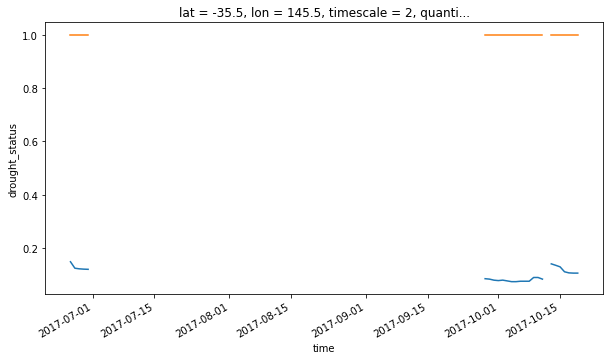

In [37]:
test_prob_band[0, 0:500, 70, 130].plot(size=5, aspect=2)
drght_status_prob_band['drought_status'][0, 70, 130, 0:500].plot()
ds_drght_status['drought_status'][0, 70, 130, 0:500].plot()

In [20]:
drought_ind = np.where(da_test == 1)[0]

In [21]:
da_test_drought = da_test.isel(time = drought_ind)

In [24]:
da_test_drought.sum()

<xarray.DataArray 'sm_drought' ()>
array(5473)
Coordinates:
    lat      float32 -35.5
    lon      float32 145.5

In [27]:
drought_time = da_test_drought.time

In [51]:
drought_after_temp

<xarray.DataArray 'time' (time: 5473)>
array(['1911-05-05T00:00:00.000000000', '1911-05-06T00:00:00.000000000',
       '1911-05-07T00:00:00.000000000', ...,
       '2021-01-12T00:00:00.000000000', '2021-01-13T00:00:00.000000000',
       '2021-01-14T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    lat      float32 -35.5
    lon      float32 145.5
  * time     (time) datetime64[ns] 1911-04-21 1911-04-22 ... 2020-12-31

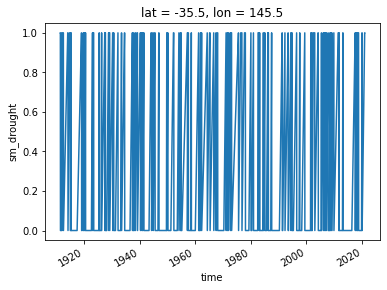

In [46]:
da_test_afterTs.plot()

In [48]:
da_test_drought2 = da_test.where(da_test==1)

In [49]:
da_test_drought2

<xarray.DataArray 'sm_drought' (time: 40178)>
array([nan, nan, nan, ...,  1.,  1.,  1.])
Coordinates:
    lat      float32 -35.5
    lon      float32 145.5
  * time     (time) datetime64[ns] 1911-01-01 1911-01-02 ... 2020-12-31

In [54]:
da_events

<xarray.DataArray 'sm_drought' (lat: 141, lon: 261, time: 40178)>
dask.array<concatenate, shape=(141, 261, 40178), dtype=int64, chunksize=(141, 261, 3653), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon      (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
  * time     (time) datetime64[ns] 1911-01-01 1911-01-02 ... 2020-12-31

In [56]:
ts = 2
da_test_afterTs = da_test[(7*ts-1):len(da_test.time)]

In [60]:
da_test_afterTs = da_test_afterTs.assign_coords({'time': da_test.time.values[0:(len(da_test.time)-7*ts+1)]})

In [61]:
da_test_afterTs

<xarray.DataArray 'sm_drought' (time: 40165)>
array([0, 0, 0, ..., 1, 1, 1])
Coordinates:
    lat      float32 -35.5
    lon      float32 145.5
  * time     (time) datetime64[ns] 1911-01-01 1911-01-02 ... 2020-12-18

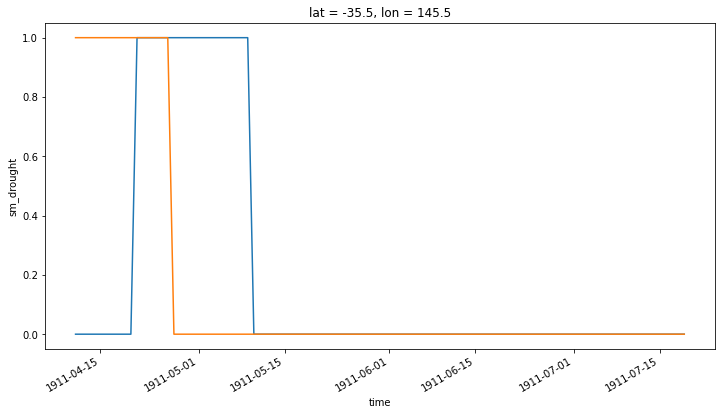

In [65]:
da_test[100:200].plot(size=6, aspect=2)
da_test_afterTs[100:200].plot()

In [67]:
da_events

<xarray.DataArray 'sm_drought' (lat: 141, lon: 261, time: 40178)>
dask.array<concatenate, shape=(141, 261, 40178), dtype=int64, chunksize=(141, 261, 3653), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon      (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
  * time     (time) datetime64[ns] 1911-01-01 1911-01-02 ... 2020-12-31

In [68]:
ts = 2
da_events_afterTs = (da_events[:,:,(7*ts-1):len(da_events.time)]).rename('sm_drought_after_' + str(ts) + 'weeks')\
.assign_coords({'time': da_events.time.values[0:(len(da_events.time)-7*ts+1)]})

In [69]:
da_events_afterTs

<xarray.DataArray 'sm_drought_after_2weeks' (lat: 141, lon: 261, time: 40165)>
dask.array<getitem, shape=(141, 261, 40165), dtype=int64, chunksize=(141, 261, 3653), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon      (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
  * time     (time) datetime64[ns] 1911-01-01 1911-01-02 ... 2020-12-18

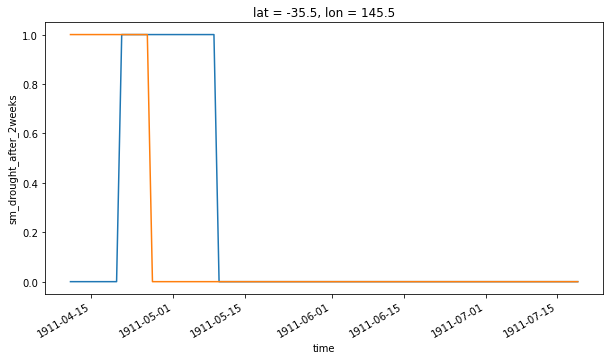

In [70]:
da_events[70, 130, 100:200].plot(size=5, aspect=2)
da_events_afterTs[70, 130, 100:200].plot()